In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
ua = pd.read_csv('datas/mars_tianchi_user_actions.csv', parse_dates='Ds', date_parser=dateparse)
so = pd.read_csv('datas/mars_tianchi_songs.csv')

In [3]:
data = pd.merge(ua, so, on=['song_id'])
arts = data[data.action_type == 1].groupby(['artist_id', 'Ds'])['action_type'].sum()
arts.to_csv('datas/arts.csv')
arts = pd.read_csv('datas/arts.csv', names=['artist_id', 'Ds', 'plays'], parse_dates='Ds', date_parser=dateparse, 
                   index_col='Ds')

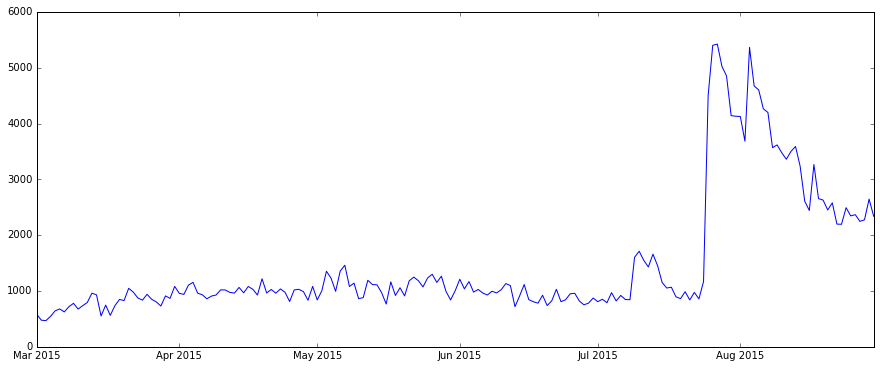

In [4]:
one = arts[arts.artist_id == '8fb3cef29f2c266af4c9ecef3b780e97']
one.pop('artist_id')
plt.plot(one)

In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

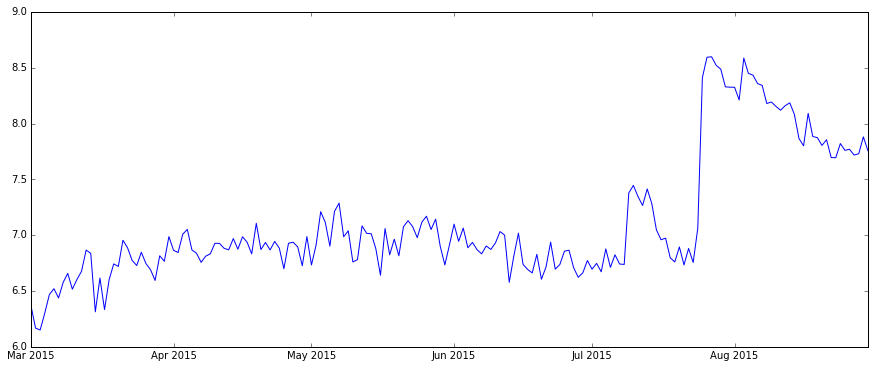

In [7]:
ts = pd.Series(data=one['plays'], index=one.index)
ts.dropna(inplace=True)
ts_log = np.log(ts)
plt.plot(ts_log)

# STL

/usr/local/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


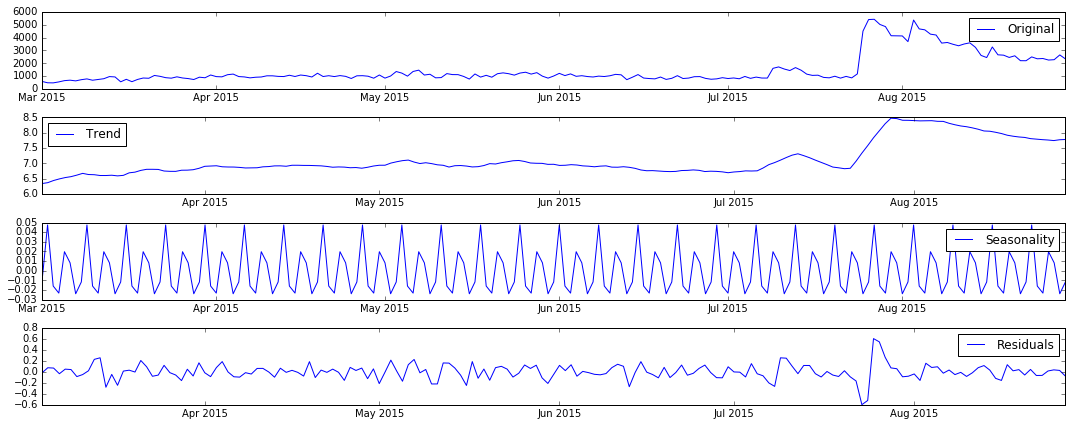

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# R

In [9]:
import rpy2.robjects as robjects
# import rpy2's package module
import rpy2.robjects.packages as rpackages
# import R's utility package
utils = rpackages.importr('utils')
# select a mirror for R packages
#utils.chooseCRANmirror(ind=1) # select the first mirror in the list
forecats = rpackages.importr('forecast')
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.robjects as ro
pandas2ri.activate()

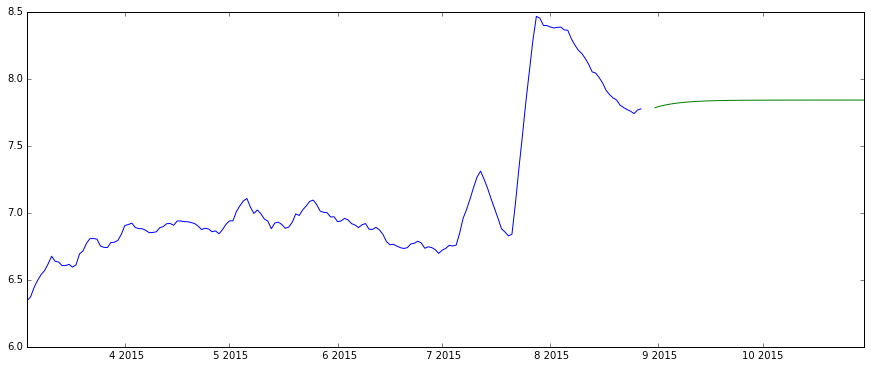

In [11]:
rdf = pandas2ri.py2ri(trend)
ro.globalenv['r_timeseries'] = rdf
pred_trend = ro.r('as.data.frame(forecast(r_timeseries, h=61))')
plt.plot(trend)
plt.plot(pd.date_range('20150831', '20151030'), pred_trend['Point Forecast'])

In [36]:
pred = pd.Series(index=pd.date_range('20150901', '20151030'),\
                           data=pred_trend['Point Forecast'].tolist()[1:])

In [10]:
residual.mean()

0.22106750392477911